# Simulation Experiments

## Load Model

In [181]:
import pysd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import numpy as np

current_dir = Path.cwd()
BASE_DIR = current_dir.parent if current_dir.name == 'notebooks' else current_dir
os.chdir(BASE_DIR)

# Load the default parameters
with open(BASE_DIR / 'params.yaml', 'r') as file:
    BASE_PARAMS = yaml.safe_load(file)

model = pysd.load('src/model.py')



## Highest Tax & Emission Trade-off

- Binary search over a tax range to find the maximum sustainable tax. 
- Simulate all taxes up to frontier and compute CO2 reduction vs profitability.

### Max Tax

In [182]:
from src.utils import calculate_max_viable_tax

tax_frontier = calculate_max_viable_tax(model, BASE_PARAMS)

print(tax_frontier)

4979


### CO2 Reduction vs Profitability

In [183]:
return_columns = [
    "cumulative_co2",
    "cumulative_profit",
    "viability_flag"
]

baseline_run = model.run(params=BASE_PARAMS, return_columns=return_columns)

co2_base = baseline_run["cumulative_co2"].iloc[-1]
profit_base = baseline_run["cumulative_profit"].iloc[-1]

# Vector of taxes to simulate. Using 100 points for now.
tax_grid = np.linspace(289, tax_frontier, 30)

results_list = []

for tax in tax_grid:
    params = BASE_PARAMS.copy()
    params["carbon_tax_rate"] = tax
    sim_results = model.run(
        params=params,
        return_columns=return_columns
    )


    co2 = sim_results["cumulative_co2"].iloc[-1]
    profit = sim_results["cumulative_profit"].iloc[-1]

    viability_flag = sim_results["viability_flag"].iloc[-1]

    co2_reduction_pct = 100 * (1 - co2 / co2_base)
    profit_change_pct = 100 * ((profit - profit_base) / profit_base)

    results_list.append({
        "tax": tax,
        "co2": co2,
        "profit": profit,
        "co2_reduction_pct": co2_reduction_pct,
        "profit_change_pct": profit_change_pct,
        "viable": viability_flag
    })

results_df = pd.DataFrame(results_list)

# assert (results_df["viable"] == 1).all(), "Some simulations are not viable"



### Visualisation

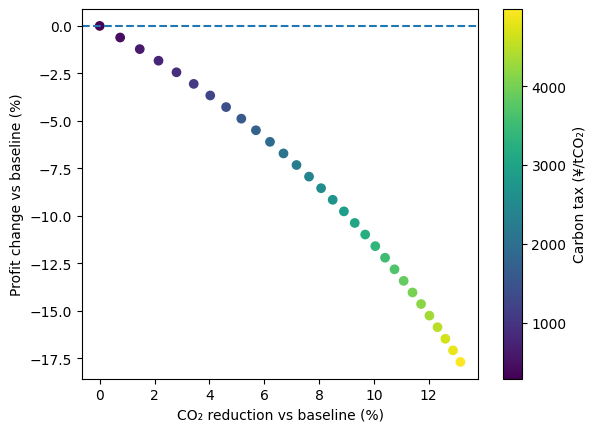

In [184]:
fig, ax = plt.subplots()

sc = ax.scatter(
    results_df["co2_reduction_pct"],
    results_df["profit_change_pct"],
    c=results_df["tax"],  # color by tax level
)
ax.axhline(0, linestyle="--")  # zero profit-change line
ax.set_xlabel("CO₂ reduction vs baseline (%)")
ax.set_ylabel("Profit change vs baseline (%)")
plt.colorbar(sc, label="Carbon tax (¥/tCO₂)")

In [185]:
x = results_df["co2_reduction_pct"]
y = results_df["profit_change_pct"]

coef_linear = np.polyfit(x, y, 1)
y_linear = np.polyval(coef_linear, x)

ss_res = np.sum((y - y_linear) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - ss_res / ss_tot

print(f"R-squared: {r_squared}")

coef_quad = np.polyfit(x, y, 2)
y_quad = np.polyval(coef_quad, x)

ss_res_q = np.sum((y - y_quad)**2)
r2_quad = 1 - ss_res_q/ss_tot

print("Quadratic fit R^2:", r2_quad)


# Sort by CO2 reduction
df_sorted = results_df.sort_values("co2_reduction_pct")
x = df_sorted["co2_reduction_pct"].values
y = df_sorted["profit_change_pct"].values

# second finite difference (approx curvature sign)
second_diff = np.diff(y, 2)  # length N-2
print("Mean second difference:", second_diff.mean())
print("Max abs second difference:", np.abs(second_diff).max())

R-squared: 0.98012701800641
Quadratic fit R^2: 0.9995936766705255
Mean second difference: 3.210368653160299e-05
Max abs second difference: 7.646241600767212e-05


## Sensitivity & Leverage Points

In [ ]:
key_params = [
    "cost_pressure_sensitivity",
    "max_efficiency",
    "tau_eff",
    "desired_passthrough_share",
    "elasticity_lr",
    "elasticity_sr",
    "max_reduction_ci",
    "nonfuel_cost_per_km",
    
    
]